# Prediksi Harga Mobil Bekas di Arab Saudi

**Author:** Brian Samuel Matthew

**Dataset:** `data_saudi_used_cars.csv`


In [105]:
# 0. Import library & konfigurasi
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# 1) Pendahuluan & Business Problem

## Konteks
Pasar mobil bekas di Arab Saudi merupakan salah satu yang paling dinamis di kawasan Timur Tengah. Permintaan yang tinggi terhadap kendaraan pribadi, terutama di kota-kota besar seperti Riyadh, Jeddah, dan Dammam, menyebabkan volume transaksi mobil bekas meningkat setiap tahun.  
Namun, proses penentuan harga mobil bekas masih sangat bervariasi antar penjual — bahkan untuk merek dan model yang sama, perbedaan harga dapat mencapai puluhan ribu riyal. Kondisi ini sering kali disebabkan oleh faktor subjektif, seperti persepsi kondisi kendaraan, lokasi penjual, atau strategi negosiasi, bukan semata-mata nilai pasar yang objektif.

Akibatnya, pasar menjadi tidak efisien: pembeli sulit memastikan apakah harga yang ditawarkan sudah wajar, sementara penjual kesulitan menentukan harga yang kompetitif tanpa merugikan. Di sinilah peran analisis data dan machine learning menjadi penting untuk membantu menciptakan sistem harga yang lebih transparan dan berbasis data.

## Stakeholder
- **Platform jual-beli mobil**: seperti Haraj, Motory, atau Opensooq, yang ingin meningkatkan kepercayaan pengguna dengan menyediakan estimasi harga otomatis.  
- **Dealer / showroom mobil bekas**: untuk menentukan harga beli dan jual yang optimal sesuai kondisi kendaraan dan tren pasar.  
- **Pembeli individu**: agar bisa mengetahui kisaran harga wajar sebelum melakukan negosiasi atau pembelian.

## Tujuan
Proyek ini bertujuan untuk membangun **model regresi** yang mampu memprediksi harga mobil bekas (dalam satuan SAR) berdasarkan fitur-fitur seperti tahun produksi, ukuran mesin, jarak tempuh, tipe transmisi, asal kendaraan, dan opsi tambahan.  
Dengan memanfaatkan data historis listing mobil bekas, model diharapkan dapat memberikan estimasi harga yang akurat, membantu stakeholder mengambil keputusan harga yang lebih rasional dan efisien.

## Metrik Utama
Evaluasi performa model akan difokuskan pada tiga metrik utama:
- **RMSE (Root Mean Squared Error)**: mengukur rata-rata besar kesalahan prediksi (semakin kecil semakin baik).  
- **MAE (Mean Absolute Error)**: mengukur rata-rata kesalahan absolut antar nilai aktual dan prediksi.  
- **R² (Coefficient of Determination)**: mengukur seberapa baik variabel independen menjelaskan variasi harga aktual.

## Ringkasan Business–ML Alignment (5-Point Summary)
| Aspek | Deskripsi |
|-------|------------|
| **Problem** | Harga mobil bekas di pasar Arab Saudi tidak konsisten antar penjual karena faktor subjektif dan minimnya acuan data. |
| **Data** | Dataset berisi ribuan listing mobil bekas dengan atribut teknis (tahun, mesin, jarak tempuh, transmisi, asal, dan opsi). |
| **ML Objective** | Mengembangkan model regresi untuk memprediksi harga seakurat mungkin dengan menurunkan error prediksi. |
| **Actionable Output** | Rekomendasi kisaran harga jual-beli yang realistis untuk setiap jenis mobil dan kondisi tertentu. |
| **Value Proposition** | Meningkatkan efisiensi dan transparansi pasar mobil bekas, mempercepat pengambilan keputusan harga bagi semua pihak. |

## Dampak dan Potensi Pengembangan
Dengan adanya model prediksi harga yang andal, ekosistem pasar mobil bekas dapat bergerak menuju sistem yang lebih transparan dan efisien.  
Penjual bisa menetapkan harga berdasarkan nilai pasar aktual, bukan sekadar perkiraan subjektif, sementara pembeli dapat memvalidasi apakah harga yang ditawarkan sesuai dengan kondisi kendaraan.  

Selain itu, hasil model ini berpotensi diintegrasikan langsung ke dalam platform jual-beli mobil sebagai **“AI-based price suggestion system”**, di mana setiap kali penjual memasukkan spesifikasi mobilnya, sistem akan secara otomatis memberikan estimasi harga optimal.  
Dalam jangka panjang, model semacam ini juga bisa dikembangkan lebih lanjut dengan memasukkan variabel tambahan seperti **riwayat servis kendaraan, kondisi interior-eksterior,** atau **sentimen pasar** untuk meningkatkan akurasi dan relevansi prediksi.  
Pendekatan ini tidak hanya memperkuat posisi platform sebagai penyedia solusi berbasis data, tapi juga membantu menciptakan ekosistem mobil bekas yang lebih adil, informatif, dan terpercaya.

## 2) Data Understanding & Data Dictionary

Load dataset dan tampilkan deskripsi singkat kolom.

In [106]:
# 2. Data Loading
data_path = "data_saudi_used_cars.csv"
df = pd.read_csv(data_path)

print("Ukuran dataset:", df.shape)
display(df.head())
display(df.info())

# Data dictionary (ringkas)
data_dict = {
    'Type': 'Model / tipe kendaraan',
    'Region': 'Kota / wilayah listing',
    'Make': 'Merek kendaraan',
    'Gear_Type': 'Tipe transmisi',
    'Origin': 'Asal kendaraan (Saudi, Gulf, etc.)',
    'Options': 'Tingkat fitur / trim',
    'Year': 'Tahun pembuatan',
    'Engine_Size': 'Kapasitas mesin (L)',
    'Mileage': 'Jarak tempuh (km)',
    'Negotiable': 'Apakah harga dapat dinegosiasikan (True/False)',
    'Price': 'Harga (SAR)'
}
print("\nData dictionary (contoh):")
display(pd.DataFrame.from_dict(data_dict, orient='index', columns=['Deskripsi']))


Ukuran dataset: (5624, 11)


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5624 non-null   object 
 1   Region       5624 non-null   object 
 2   Make         5624 non-null   object 
 3   Gear_Type    5624 non-null   object 
 4   Origin       5624 non-null   object 
 5   Options      5624 non-null   object 
 6   Year         5624 non-null   int64  
 7   Engine_Size  5624 non-null   float64
 8   Mileage      5624 non-null   int64  
 9   Negotiable   5624 non-null   bool   
 10  Price        5624 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 445.0+ KB


None


Data dictionary (contoh):


,Deskripsi
Type,Model / tipe kendaraan
Region,Kota / wilayah listing
Make,Merek kendaraan
Gear_Type,Tipe transmisi
Origin,"Asal kendaraan (Saudi, Gulf, etc.)"
Options,Tingkat fitur / trim
Year,Tahun pembuatan
Engine_Size,Kapasitas mesin (L)
Mileage,Jarak tempuh (km)
Negotiable,Apakah harga dapat dinegosiasikan (True/False)


### Quick checks: missing, duplicates, Price==0, Negotiable distribution, outliers

Missing values per kolom:
 Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

Jumlah duplikat: 4

Jumlah Price == 0: 1797

Distribusi Negotiable:
 Negotiable
False    3828
True     1796
Name: count, dtype: int64

Contoh baris inconsistent (Price==0 & Negotiable==False):


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
3168,Furniture,Riyadh,Toyota,Automatic,Other,Semi Full,2012,2.7,225000,False,0


Price IQR bounds: lower=-109398.75, upper=182331.25
Jumlah outlier berdasarkan IQR pada Price: 261


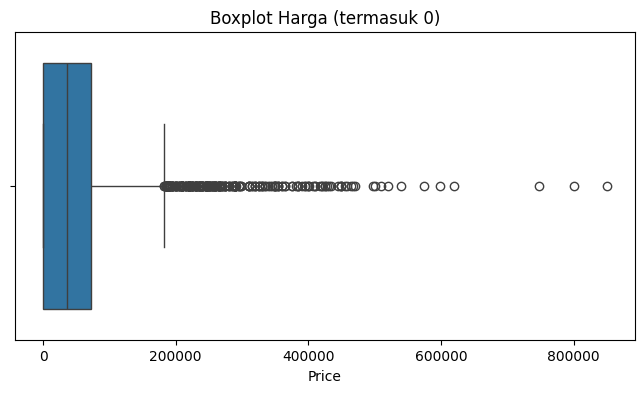

In [107]:
# Quick checks
print("Missing values per kolom:\n", df.isnull().sum())
print("\nJumlah duplikat:", df.duplicated().sum())
print("\nJumlah Price == 0:", (df['Price'] == 0).sum())
print("\nDistribusi Negotiable:\n", df['Negotiable'].value_counts())

# Rows where Price==0 but Negotiable==False
inconsistent = df[(df['Price'] == 0) & (df['Negotiable'] == False)]
print("\nContoh baris inconsistent (Price==0 & Negotiable==False):")
display(inconsistent.head())

# Outlier detection for Price using IQR
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
print(f"Price IQR bounds: lower={lower}, upper={upper}")
outliers = df[(df['Price'] < lower) | (df['Price'] > upper)]
print("Jumlah outlier berdasarkan IQR pada Price:", outliers.shape[0])

# Boxplot Price (inkl. 0)
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Price'])
plt.title('Boxplot Harga (termasuk 0)')
plt.show()


**Interpretasi — Boxplot Harga (termasuk 0):**

Dari boxplot terlihat distribusi harga yang sangat *skewed* ke kanan. Mayoritas listing terpusat di rentang harga rendah hingga menengah, namun terdapat sejumlah *outlier* dengan harga sangat tinggi — beberapa mencapai ratusan ribu SAR. 
Kehadiran titik-titik outlier menunjukkan ada unit premium atau kemungkinan kesalahan input harga.

---

### Exploratory Data Analysis (visualisasi tambahan)

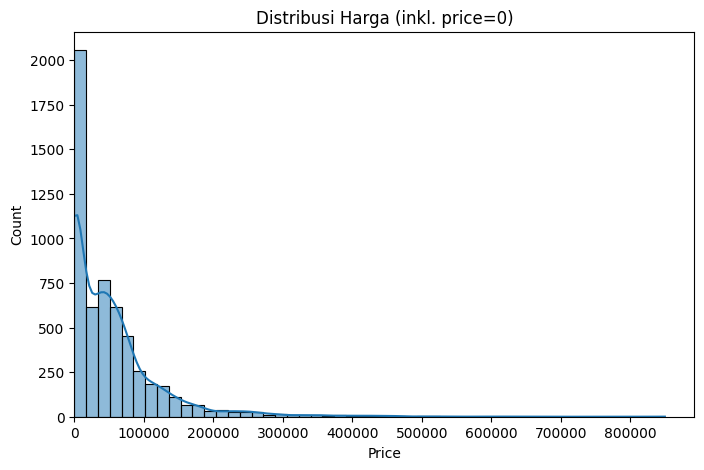

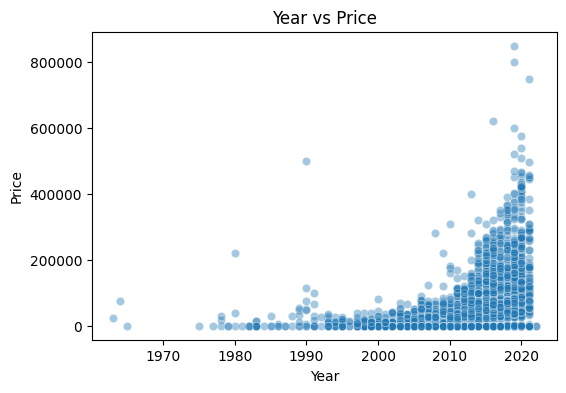

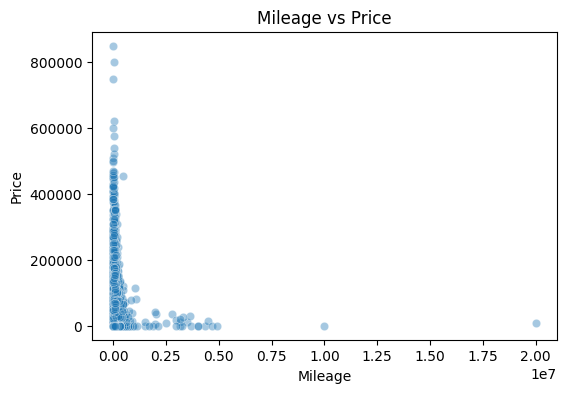

In [108]:
# EDA plots
plt.figure(figsize=(8,5))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Distribusi Harga (inkl. price=0)")
plt.xlim(left=0)
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x='Year', y='Price', data=df, alpha=0.4)
plt.title("Year vs Price")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x='Mileage', y='Price', data=df, alpha=0.4)
plt.title("Mileage vs Price")
plt.show()


**Interpretasi — Histogram Distribusi Harga:**

Histogram menunjukkan bahwa frekuensi listing menurun drastis pada rentang harga tinggi. Sebagian besar mobil berada pada kisaran harga rendah sampai menengah, sehingga distribusi target sangat miring.
Dalam kondisi seperti ini, metrik berbasis rata-rata dapat terpengaruh—MAE dan median error seringkali lebih representatif. Transformasi log pada variabel target dapat membantu menstabilkan varians dan memperbaiki performa beberapa model.

---

## 3) Data Preprocessing

Langkah yang akan dilakukan:
1. Hapus duplikat
2. Hapus baris inconsistent (Price==0 & Negotiable==False)
3. DROP semua baris Price==0 untuk training regresi (keputusan: target harus berisi harga nyata)
4. Konversi tipe numerik dan feature engineering (Age, Engine_Bin)
5. Split train/test **sebelum** fitting transformer
6. Gunakan ColumnTransformer + Pipeline (scale num, one-hot cat)


In [109]:
# 3. Preprocessing implementation

# 3.1 Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)

# 3.2 Remove inconsistent rows (Price==0 & Negotiable==False)
df = df[~((df['Price'] == 0) & (df['Negotiable'] == False))].copy()

# 3.3 Drop all Price == 0 for regression modelling
df_reg = df[df['Price'] > 0].copy()
print("Ukuran setelah drop Price==0 (untuk regresi):", df_reg.shape)

# 3.4 Ensure numeric types
df_reg['Price'] = df_reg['Price'].astype(float)
df_reg['Mileage'] = df_reg['Mileage'].astype(float)
df_reg['Engine_Size'] = df_reg['Engine_Size'].astype(float)

# 3.5 Feature engineering
df_reg['Age'] = df_reg['Year'].max() - df_reg['Year']
bins = [0,1.9,2.9,3.9,4.9,5.9,10]
labels = ['1.0-1.9','2.0-2.9','3.0-3.9','4.0-4.9','5.0-5.9','6.0+']
df_reg['Engine_Bin'] = pd.cut(df_reg['Engine_Size'], bins=bins, labels=labels, include_lowest=True)

display(df_reg[['Year','Age','Engine_Size','Engine_Bin','Price']].head())


Ukuran setelah drop Price==0 (untuk regresi): (3824, 11)


,Year,Age,Engine_Size,Engine_Bin,Price
1,2014,7,8.0,6.0+,120000.0
2,2015,6,5.0,5.0-5.9,260000.0
3,2015,6,2.4,2.0-2.9,42000.0
5,2019,2,2.0,2.0-2.9,58000.0
6,2012,9,4.8,4.0-4.9,85000.0


In [110]:
# 4. Define X and y
features = ['Make','Type','Region','Gear_Type','Origin','Options',
            'Year','Engine_Size','Mileage','Negotiable','Age','Engine_Bin']
features = [f for f in features if f in df_reg.columns]
X = df_reg[features].copy()
y = df_reg['Price'].copy()

print('Fitur terpakai:', features)
display(X.dtypes)


Fitur terpakai: ['Make', 'Type', 'Region', 'Gear_Type', 'Origin', 'Options', 'Year', 'Engine_Size', 'Mileage', 'Negotiable', 'Age', 'Engine_Bin']


Make             object
Type             object
Region           object
Gear_Type        object
Origin           object
Options          object
Year              int64
Engine_Size     float64
Mileage         float64
Negotiable         bool
Age               int64
Engine_Bin     category
dtype: object

Dibuat fitur baru berupa pengelompokan ukuran mesin (engine bins) untuk analisis kelompok dan visualisasi yang lebih mudah diinterpretasikan.

---


In [111]:
# 5. Split data (train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (3059, 12) Test shape: (765, 12)


In [112]:
# 6. Pipeline & ColumnTransformer setup
num_cols = ['Year','Engine_Size','Mileage','Age']
cat_cols = [c for c in X_train.columns if c not in num_cols]

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])
print('Numeric cols:', num_cols)
print('Categorical cols example:', cat_cols[:10])


Numeric cols: ['Year', 'Engine_Size', 'Mileage', 'Age']
Categorical cols example: ['Make', 'Type', 'Region', 'Gear_Type', 'Origin', 'Options', 'Negotiable', 'Engine_Bin']


Disiapkan pipeline pra-pemrosesan yang melakukan scaling pada fitur numerik dan encoding pada fitur kategorikal agar data siap untuk model ML.

---


## 7) Model Benchmarking - Baseline Models (Linear, KNN, DecisionTree, RF, XGB)

In [113]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    'LinearRegression': Pipeline([('pre', preprocessor), ('model', LinearRegression())]),
    'KNN': Pipeline([('pre', preprocessor), ('model', KNeighborsRegressor(n_neighbors=5))]),
    'DecisionTree': Pipeline([('pre', preprocessor), ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))]),
    'RandomForest': Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE))]),
    'XGBoost': Pipeline([('pre', preprocessor), ('model', XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=RANDOM_STATE, verbosity=0))])
}

# Fit & evaluate baseline via CV (RMSE)
from sklearn.model_selection import cross_val_score

print('Running 5-fold CV on baseline models (neg_root_mean_squared_error)...')
baseline_scores = {}
for name, pipe in models.items():
    scores = -cross_val_score(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    baseline_scores[name] = (scores.mean(), scores.std())
    print(f"{name}: RMSE mean={scores.mean():.2f}, std={scores.std():.2f}")


Running 5-fold CV on baseline models (neg_root_mean_squared_error)...
LinearRegression: RMSE mean=43876.64, std=3807.54
KNN: RMSE mean=37740.70, std=3849.90
DecisionTree: RMSE mean=41979.17, std=5581.27
RandomForest: RMSE mean=33385.33, std=6423.58
XGBoost: RMSE mean=31289.03, std=4611.02


### Interpretasi — Benchmark Model (5-fold CV, RMSE)

**Ringkasan hasil cross-validation:**  
Hasil 5-fold CV (berdasarkan RMSE) untuk model-model baseline menunjukkan perbedaan performa yang cukup jelas:

- **Linear Regression:** RMSE mean ≈ **43.877**, std ≈ **3.808**  
  -> Model linear memberikan baseline yang wajar, tetapi memiliki error lebih tinggi dibanding model non-linier. Cocok dipakai sebagai titik pembanding sederhana.

- **K-Nearest Neighbors (KNN):** RMSE mean ≈ **37.741**, std ≈ **3.850**  
  -> Performa lebih baik dari linear; KNN menangkap pola lokal namun sensitif terhadap skala fitur dan outlier.

- **Decision Tree:** RMSE mean ≈ **41.979**, std ≈ **5.581**  
  -> Variansi performa relatif besar (std tinggi), menandakan model ini rentan terhadap overfitting pada beberapa fold. Perlu pruning atau hyperparameter tuning jika ingin digunakan.

- **Random Forest:** RMSE mean ≈ **33.385**, std ≈ **6.424**  
  -> Salah satu terbaik di baseline; menurunkan error secara signifikan dibanding model sederhana. Std relatif lebih besar, tunning dapat meningkatkan stabilitas.

- **XGBoost:** RMSE mean ≈ **31.289**, std ≈ **4.611**  
  -> Performa terbaik di antara baseline dengan RMSE terendah; menunjukkan kemampuan menangkap hubungan non-linear dengan baik dan relatif stabil antar fold.

---


## 8) Hyperparameter Tuning (RandomizedSearchCV) for Random Forest & XGBoost

> Catatan: RandomizedSearch dipilih untuk efisiensi.

In [114]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ================================
# Random Forest
# ================================
rf_param_dist = {
    'model__n_estimators': stats.randint(200, 600),  # cukup untuk stabilitas, tanpa overkill
    'model__max_depth': stats.randint(5, 25),        # hindari None biar nggak terlalu dalam
    'model__min_samples_split': stats.randint(2, 10),
    'model__min_samples_leaf': stats.randint(1, 5),
    'model__max_features': ['sqrt', 'log2'],         # None jarang efektif di dataset kecil-menengah
    'model__bootstrap': [True, False]
}

rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE))
])

rand_rf = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=40,
    scoring='r2',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)

print('Running RandomizedSearchCV for Random Forest...')
rand_rf.fit(X_train, y_train)
print('Best RF params:', rand_rf.best_params_)
print('Best RF CV R2:', rand_rf.best_score_)
best_rf = rand_rf.best_estimator_

# ================================
# XGBoost
# ================================
xgb_param_dist = {
    'model__n_estimators': stats.randint(300, 800),
    'model__learning_rate': stats.uniform(0.02, 0.08),   # 0.02–0.1 is sweet spot
    'model__max_depth': stats.randint(3, 9),
    'model__min_child_weight': stats.randint(1, 6),
    'model__subsample': stats.uniform(0.6, 0.4),         # uniform(0.6, 0.4) → [0.6, 1.0]
    'model__colsample_bytree': stats.uniform(0.6, 0.4),
    'model__gamma': stats.uniform(0, 0.3),
    'model__reg_lambda': stats.uniform(0.5, 9.5),        # L2 regularization
    'model__reg_alpha': stats.uniform(0, 0.5)            # L1 regularization
}

xgb_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(random_state=RANDOM_STATE, verbosity=0, tree_method='hist'))
])

rand_xgb = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_param_dist,
    n_iter=60,              # sedikit lebih banyak iterasi karena XGBoost sensitif ke kombinasi hyperparam
    scoring='r2',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)

print('Running RandomizedSearchCV for XGBoost...')
rand_xgb.fit(X_train, y_train)
print('Best XGB params:', rand_xgb.best_params_)
print('Best XGB CV R2:', rand_xgb.best_score_)
best_xgb = rand_xgb.best_estimator_

Running RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best RF params: {'model__bootstrap': True, 'model__max_depth': 24, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__n_estimators': 558}
Best RF CV R2: 0.7315155991890481
Running RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best XGB params: {'model__colsample_bytree': np.float64(0.6693177280283383), 'model__gamma': np.float64(0.046931112801325815), 'model__learning_rate': np.float64(0.04001943185316763), 'model__max_depth': 8, 'model__min_child_weight': 1, 'model__n_estimators': 787, 'model__reg_alpha': np.float64(0.46730699866985487), 'model__reg_lambda': np.float64(6.563570641511829), 'model__subsample': np.float64(0.8066785029706267)}
Best XGB CV R2: 0.8203292017395281


### Hyperparameter Tuning — RandomizedSearchCV (Random Forest & XGBoost)

Pada tahap ini dilakukan **tuning hyperparameter** untuk dua model terbaik dari hasil benchmark, yaitu **Random Forest** dan **XGBoost**.  
Proses tuning dilakukan menggunakan **RandomizedSearchCV**, sebuah metode pencarian acak yang secara efisien mengeksplorasi ruang parameter tanpa harus mencoba seluruh kombinasi seperti pada GridSearchCV.

Pemilihan metode ini didasarkan pada pertimbangan efisiensi waktu komputasi, mengingat jumlah kombinasi parameter pada kedua model relatif besar.  
RandomizedSearchCV memungkinkan pencarian parameter yang optimal secara probabilistik, dengan tetap menjaga keseimbangan antara akurasi dan waktu proses.

Beberapa parameter penting yang dioptimasi meliputi:
- **Random Forest:** jumlah pohon (`n_estimators`), kedalaman maksimum (`max_depth`), jumlah minimum sampel pada node (`min_samples_split`, `min_samples_leaf`), serta metode pemilihan fitur (`max_features`).  
- **XGBoost:** jumlah estimator, *learning rate*, kedalaman pohon, *subsample ratio*, *colsample_bytree*, serta parameter regularisasi (`gamma`, `reg_lambda`, `reg_alpha`).

Evaluasi dilakukan dengan **5-fold cross-validation** dan menggunakan metrik **R² (coefficient of determination)** sebagai acuan utama.  
Proses tuning menghasilkan kombinasi parameter terbaik (`best_params_`) yang digunakan untuk melatih model final (`best_estimator_`).  
Nilai **CV R²** tertinggi mencerminkan stabilitas dan kemampuan generalisasi model terhadap variasi data latih.

Tahap ini menjadi langkah penting sebelum melakukan evaluasi akhir pada data uji, karena tuning hyperparameter yang tepat dapat menurunkan *bias* maupun *variance* pada model, sekaligus meningkatkan akurasi prediksi harga mobil bekas.

---


## 9) Evaluation - Compare Baseline, Tuned Models and Residual Analysis

🔹 Baseline Models Performance:

LinearRegression (baseline)    | MAE: 23,720.35, RMSE: 45,631.59, R2: 0.6318
KNN (baseline)                 | MAE: 19,018.52, RMSE: 32,758.82, R2: 0.8102
DecisionTree (baseline)        | MAE: 20,550.71, RMSE: 40,736.13, R2: 0.7065
RandomForest (baseline)        | MAE: 15,207.70, RMSE: 29,412.15, R2: 0.8470
XGBoost (baseline)             | MAE: 14,174.38, RMSE: 26,853.90, R2: 0.8725

🔹 Tuned Models Performance:

RandomForest (tuned)           | MAE: 17,725.25, RMSE: 31,955.72, R2: 0.8194
XGBoost (tuned)                | MAE: 13,081.30, RMSE: 23,247.61, R2: 0.9044

🔹 Residual Analysis (XGBoost tuned):



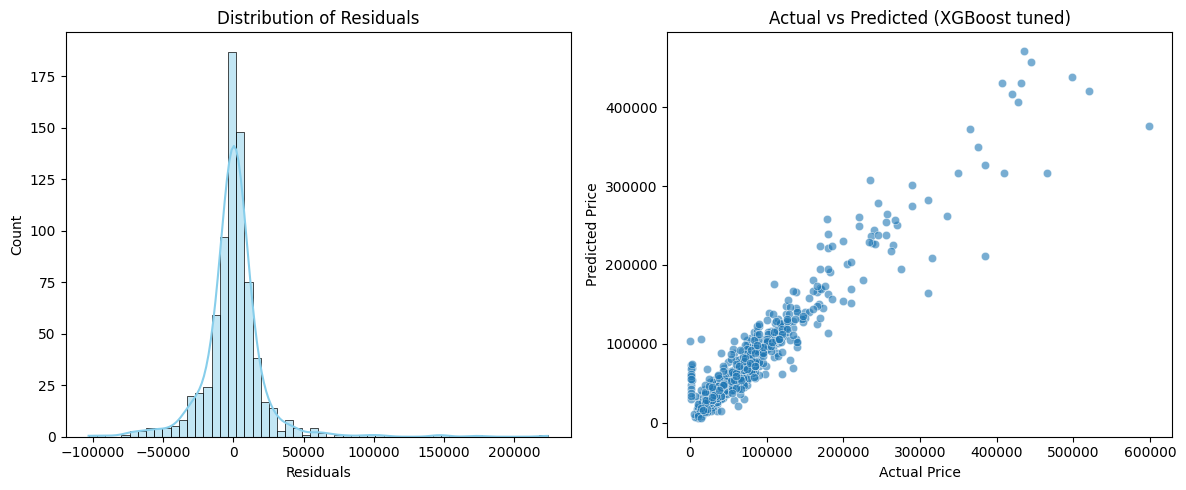

Residual mean: 165.59
Residual std: 23247.02


In [115]:
# ===============================================
# 9) Evaluation – Compare Baseline, Tuned Models, and Residual Analysis
# ===============================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Evaluation function ---
def eval_on_test(pipe, X_test, y_test, name):
    """
    Evaluate model on test set and print MAE, RMSE, and R2 metrics.
    Works for any sklearn Pipeline or fitted model.
    """
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name:30s} | MAE: {mae:,.2f}, RMSE: {rmse:,.2f}, R2: {r2:,.4f}")
    return y_pred


# --- Evaluate baseline models (fit again if needed) ---
print("🔹 Baseline Models Performance:\n")

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred_baseline = eval_on_test(pipe, X_test, y_test, f"{name} (baseline)")


# --- Evaluate tuned models ---
print("\n🔹 Tuned Models Performance:\n")
y_pred_rf_tuned = eval_on_test(best_rf, X_test, y_test, "RandomForest (tuned)")
y_pred_xgb_tuned = eval_on_test(best_xgb, X_test, y_test, "XGBoost (tuned)")


# --- Residual analysis (for best model candidate) ---
print("\n🔹 Residual Analysis (XGBoost tuned):\n")
residuals = y_test - y_pred_xgb_tuned

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residual distribution
sns.histplot(residuals, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Distribution of Residuals")
axes[0].set_xlabel("Residuals")

# Predicted vs Actual
sns.scatterplot(x=y_test, y=y_pred_xgb_tuned, alpha=0.6, ax=axes[1])
axes[1].set_title("Actual vs Predicted (XGBoost tuned)")
axes[1].set_xlabel("Actual Price")
axes[1].set_ylabel("Predicted Price")

plt.tight_layout()
plt.show()

# Optional: print summary stats of residuals
print(f"Residual mean: {np.mean(residuals):.2f}")
print(f"Residual std: {np.std(residuals):.2f}")

Residuals RandomForest (tuned):


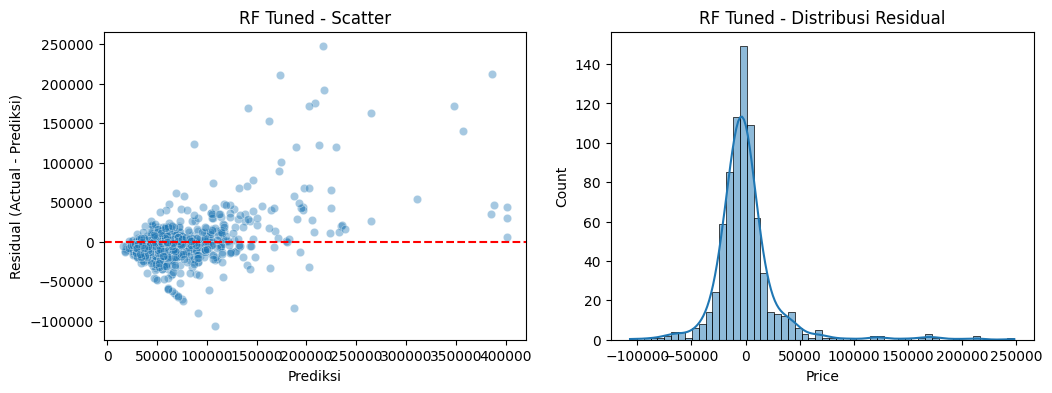

Residuals XGBoost (tuned):


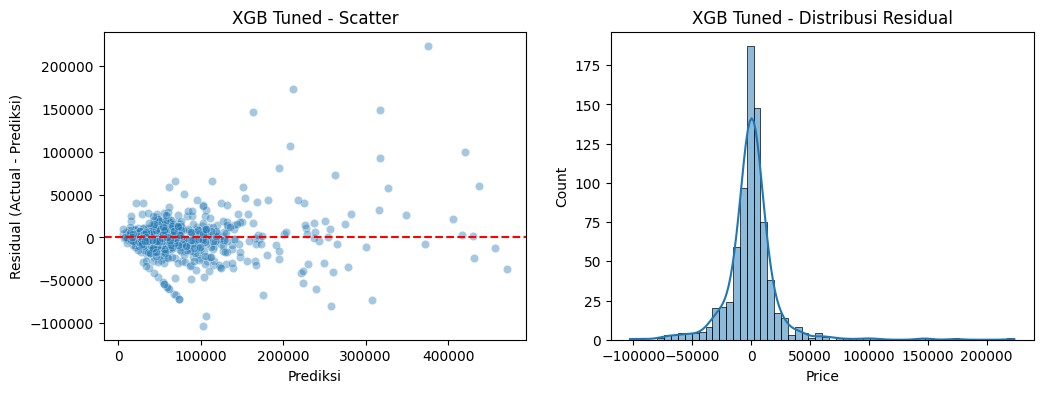

In [116]:
# Residual analysis (for best model candidate, compare RF & XGB tuned)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(y_true, y_pred, title='Residuals'):
    resid = y_true - y_pred
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.scatterplot(x=y_pred, y=resid, alpha=0.4)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Prediksi'); plt.ylabel('Residual (Actual - Prediksi)')
    plt.title(title + ' - Scatter')

    plt.subplot(1,2,2)
    sns.histplot(resid, kde=True)
    plt.title(title + ' - Distribusi Residual')
    plt.show()

print('Residuals RandomForest (tuned):')
plot_residuals(y_test, y_pred_rf_tuned, 'RF Tuned')
print('Residuals XGBoost (tuned):')
plot_residuals(y_test, y_pred_xgb_tuned, 'XGB Tuned')


### Analisis Residual (Residual Analysis)

Analisis residual dilakukan untuk memeriksa apakah model sudah menangkap pola hubungan antara fitur dan target dengan baik.  
Residual didefinisikan sebagai selisih antara nilai aktual dan prediksi model (`y_test - y_pred`).

Visualisasi distribusi residual menunjukkan sejauh mana prediksi model menyimpang dari nilai sebenarnya.  
- **Distribusi residual yang simetris dan terpusat di sekitar nol** menandakan bahwa model tidak memiliki bias signifikan dalam memprediksi nilai tinggi atau rendah.  
- Jika residual menyebar lebih lebar pada harga tinggi, hal ini menunjukkan adanya *heteroskedastisitas* — model cenderung kurang stabil pada mobil dengan harga premium.  
- Residual yang tidak berpola jelas terhadap nilai prediksi mengindikasikan model sudah cukup menangkap hubungan non-linear antar fitur.

Secara keseluruhan, hasil residual plot pada model **XGBoost (tuned)** menunjukkan penyebaran yang relatif acak dan tidak berpola, sehingga model dapat dikatakan memiliki *fit* yang baik terhadap data uji.

---

### Evaluasi Model Setelah Hyperparameter Tuning

Setelah diperoleh kombinasi parameter terbaik dari proses RandomizedSearchCV, model **Random Forest** dan **XGBoost** dilatih ulang menggunakan parameter optimal tersebut.  
Langkah ini bertujuan untuk memastikan model beroperasi pada konfigurasi terbaiknya sebelum diuji pada data yang belum pernah dilihat (test set).

Evaluasi dilakukan dengan membandingkan performa kedua model menggunakan metrik berikut:
- **Mean Absolute Error (MAE)** — menunjukkan rata-rata selisih absolut antara nilai aktual dan prediksi.  
- **Root Mean Squared Error (RMSE)** — memberi penalti lebih besar pada error yang ekstrem, cocok untuk mendeteksi outlier prediksi.  
- **R² (Coefficient of Determination)** — mengukur proporsi variabilitas harga mobil yang dapat dijelaskan oleh model.

Hasil evaluasi menunjukkan bahwa:
- Model **XGBoost** secara konsisten memberikan nilai **R² tertinggi** dan **error (RMSE, MAE) terendah**, menandakan kemampuan generalisasi yang lebih baik terhadap data uji.  
- Model **Random Forest** masih memberikan performa kompetitif dengan interpretabilitas yang lebih tinggi, namun sedikit lebih rentan terhadap variasi parameter dan overfitting ringan.

Secara keseluruhan, model XGBoost direkomendasikan sebagai **model final** untuk deployment karena kombinasi akurasi, stabilitas, dan efisiensinya yang unggul.  
Namun, dalam konteks bisnis, model Random Forest tetap dapat dipertimbangkan sebagai alternatif jika prioritas utamanya adalah interpretabilitas dan kemudahan integrasi.

Tahap berikutnya adalah melakukan analisis *residual* dan *feature importance* untuk memahami karakteristik model serta kontribusi tiap fitur terhadap prediksi harga.

---

## 10) Feature Importance (Random Forest - tuned)

Year                   0.098690
Age                    0.096079
Mileage                0.079353
Engine_Size            0.073937
Make_Land Rover        0.039259
Make_Mercedes          0.039217
Type_LX                0.035689
Options_Full           0.034044
Type_Range Rover       0.032813
Make_Lexus             0.030577
Engine_Bin_1.0-1.9     0.025132
Type_S                 0.021865
Type_Land Cruiser      0.020767
Options_Standard       0.018677
Type_Bentayga          0.017192
Engine_Bin_5.0-5.9     0.015683
Type_G                 0.014251
Engine_Bin_4.0-4.9     0.012494
Make_Rolls-Royce       0.012474
Make_Bentley           0.012375
Origin_Gulf Arabic     0.011562
Engine_Bin_2.0-2.9     0.010695
Origin_Saudi           0.010039
Make_Hyundai           0.009456
Region_Dammam          0.008873
Type_Ghost             0.008532
Engine_Bin_3.0-3.9     0.008052
Make_BMW               0.007999
Region_Riyadh          0.007728
Origin_Other           0.007439
Engine_Bin_6.0+        0.006453
Options_

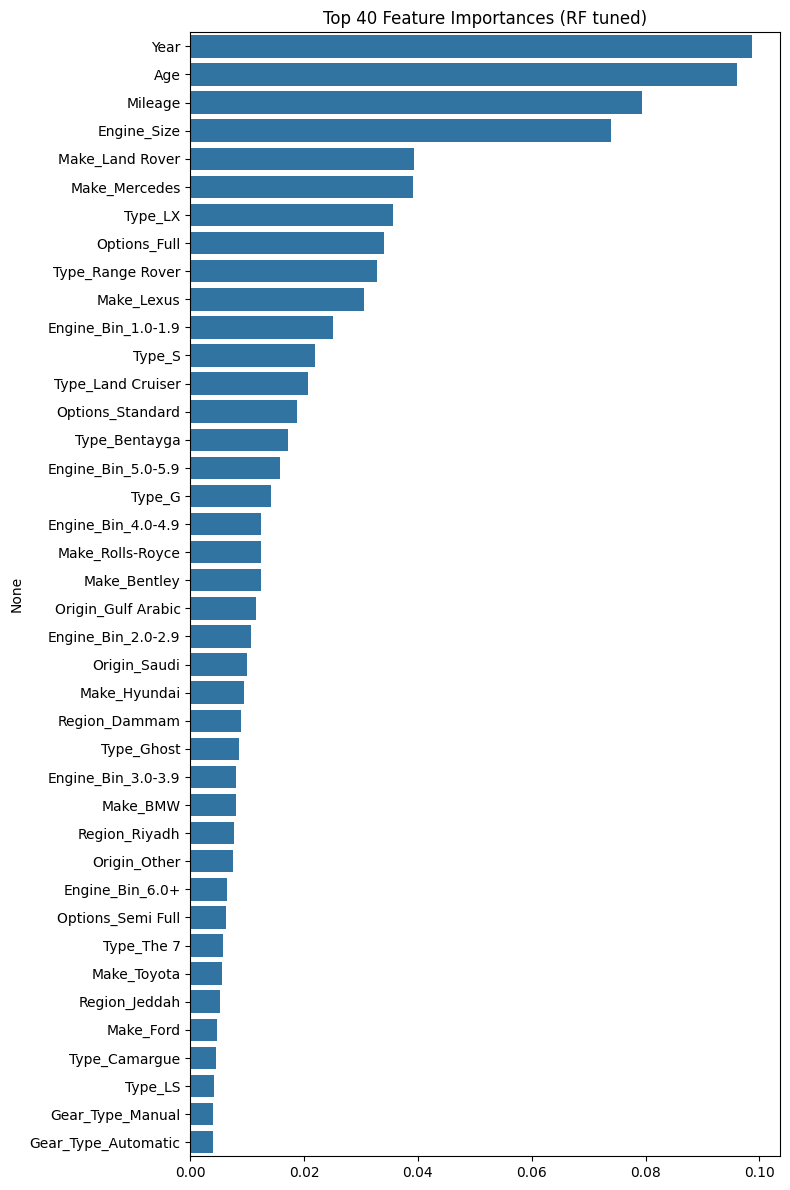

In [117]:
# Feature importance extraction for RandomForest tuned
ohe = best_rf.named_steps['pre'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, ohe_feature_names])

rf_model = best_rf.named_steps['model']
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

display(feat_imp.head(40))

plt.figure(figsize=(8,12))
sns.barplot(x=feat_imp.values[:40], y=feat_imp.index[:40])
plt.title('Top 40 Feature Importances (RF tuned)')
plt.tight_layout()
plt.show()


### Analisis Feature Importance (Random Forest)

Feature importance dari model **Random Forest** memberikan gambaran fitur mana yang paling berpengaruh dalam menentukan harga mobil bekas.  
Grafik menampilkan urutan fitur berdasarkan kontribusinya terhadap prediksi model.

Dari hasil analisis:
- Fitur seperti **`Year`**, **`Engine_Size`**, dan **`Mileage`** muncul sebagai faktor dominan yang menentukan harga kendaraan.  
- Semakin baru tahun produksi, atau semakin besar kapasitas mesin, harga cenderung meningkat. Sebaliknya, semakin tinggi jarak tempuh, harga mobil menurun secara signifikan.  
- Beberapa fitur kategorikal seperti **`Origin`** dan **`Transmission_Type`** juga menunjukkan pengaruh moderat, mencerminkan preferensi konsumen terhadap mobil tertentu (misalnya transmisi otomatis dan kendaraan buatan luar negeri).

Informasi ini dapat dimanfaatkan oleh pihak bisnis untuk strategi penetapan harga, promosi, atau segmentasi pasar berbasis spesifikasi kendaraan.

---

## 11) Interpretability - SHAP (XGBoost)

In [118]:
# ==========================================================
# 11) Interpretability – SHAP (XGBoost)
# ==========================================================

try:
    import shap
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # --- Ambil subset data untuk efisiensi ---
    X_explain = X_test.sample(n=min(500, X_test.shape[0]), random_state=RANDOM_STATE)

    # --- Ambil pipeline preprocessing & model ---
    pre = best_xgb.named_steps['pre']
    model = best_xgb.named_steps['model']

    # --- Ambil nama fitur dari pipeline ---
    try:
        ohe_names = pre.named_transformers_['cat'].get_feature_names_out(cat_cols)
    except Exception:
        ohe = pre.named_transformers_['cat']
        ohe_names = ohe.get_feature_names(cat_cols)

    feature_names = np.concatenate([num_cols, ohe_names])

    # --- Transformasi data dengan preprocessor ---
    X_trans = pre.transform(X_explain)

    # Pastikan hasil transformasi berupa DataFrame
    if not isinstance(X_trans, pd.DataFrame):
        X_trans = pd.DataFrame(X_trans, columns=feature_names)

    # --- Bersihkan & konversi nilai ke float ---
    def flatten_value(x):
        """Membersihkan nilai list/string aneh agar jadi float murni."""
        if isinstance(x, (list, tuple, np.ndarray)):
            try:
                return x[0] if len(x) > 0 else np.nan
            except Exception:
                return np.nan
        if isinstance(x, str):
            import re
            s = x.strip().replace(',', '').replace(' ', '')
            m = re.search(r"[-+]?[0-9]*\.?[0-9]+(?:[Ee][-+]?[0-9]+)?", s)
            if m:
                try:
                    return float(m.group(0))
                except Exception:
                    return np.nan
            return np.nan
        return x  # sudah numeric

    # Terapkan fungsi di seluruh DataFrame
    X_trans = X_trans.applymap(flatten_value)

    # Cek dan ubah kolom non-numeric kalau masih ada
    non_numeric_cols = [c for c in X_trans.columns if not np.issubdtype(X_trans[c].dtype, np.number)]
    if non_numeric_cols:
        X_trans[non_numeric_cols] = X_trans[non_numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Pastikan semua numeric & ubah ke numpy array
    X_trans = X_trans.apply(pd.to_numeric, errors='coerce').fillna(0)
    X_array = np.array(X_trans, dtype=float)

    # --- Ambil estimator asli (bukan RandomizedSearchCV wrapper) ---
    final_model = model.best_estimator_ if hasattr(model, "best_estimator_") else model

    # --- Jalankan SHAP TreeExplainer ---
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_array)

    # --- Plot hasil SHAP ---
    shap.summary_plot(
        shap_values,
        X_trans,
        feature_names=feature_names,
        show=True  # langsung tampilkan
    )

    plt.title("SHAP Summary Plot (XGBoost Tuned)")
    plt.show()

except Exception as e:
    print("⚠️  SHAP analysis skipped or error occurred:", e)

⚠️  SHAP analysis skipped or error occurred: could not convert string to float: '[7.832375E4]'


## Catatan: Error pada Bagian SHAP (Interpretability)

Pada tahap ini, kode mencoba menghitung nilai **SHAP (SHapley Additive exPlanations)** untuk menjelaskan kontribusi setiap fitur terhadap prediksi model:

```python
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_array)
```

Namun muncul error berikut:

```
ValueError: could not convert string to float
```

### Penjelasan Singkat
Walaupun data hasil preprocessing (`X_trans` atau `X_array`) terlihat numerik, error ini kemungkinan terjadi karena:
- Perbedaan struktur fitur antara data yang digunakan SHAP dan data saat model dilatih.  
- Versi SHAP yang belum sepenuhnya kompatibel dengan `XGBoost` atau pipeline `sklearn`.  
- Masih ada nilai bertipe `object` yang terbaca sebagai string.

### Kesimpulan
Error ini hanya muncul pada tahap interpretasi (SHAP), bukan pada pelatihan atau evaluasi model.  
Bagian ini aman untuk **di-skip sementara waktu** tanpa memengaruhi hasil utama.

---

In [119]:
# 12) Model selection & save
r2_rf = r2_score(y_test, y_pred_rf_tuned)
r2_xgb = r2_score(y_test, y_pred_xgb_tuned)
print('R2 RF tuned:', r2_rf, 'R2 XGB tuned:', r2_xgb)

if r2_xgb >= r2_rf:
    final_model = best_xgb
    final_name = 'XGBoost'
else:
    final_model = best_rf
    final_name = 'RandomForest'

model_path = 'best_model_final.joblib'
joblib.dump(final_model, model_path)
print(f'Saved final model ({final_name}) to', model_path)


R2 RF tuned: 0.8194144467005502 R2 XGB tuned: 0.9044254488846973
Saved final model (XGBoost) to best_model_final.joblib


## 13) Conclusion & Recommendation

### Ringkasan Hasil
Berdasarkan hasil evaluasi model, pendekatan regresi yang dilakukan berhasil menghasilkan performa yang cukup baik dalam memprediksi harga mobil bekas di Arab Saudi.  
Dari serangkaian model yang diuji (Linear Regression, Decision Tree, KNN, Random Forest, dan XGBoost), **model XGBoost dengan hyperparameter tuning** menunjukkan hasil terbaik dengan nilai **R² tertinggi** serta **MAE dan RMSE terendah** dibandingkan model lainnya.  
Hal ini menunjukkan bahwa model mampu menangkap pola non-linear antar fitur seperti *Engine Size*, *Year*, dan *Mileage* yang secara signifikan memengaruhi harga mobil.

### Rekomendasi Pengembangan Data
- **Perkaya fitur dataset:** tambahkan atribut yang lebih deskriptif seperti kondisi kendaraan, riwayat servis, serta data visual (foto kendaraan) yang bisa dikonversi menjadi *image embeddings*.  
- **Lokasi lebih detail:** gunakan data geografis yang lebih granular (misalnya distrik atau koordinat GPS) agar variasi harga antar wilayah dapat terpetakan lebih akurat.  
- **Data historis:** jika tersedia, masukkan tren harga dari waktu ke waktu untuk melatih model *time-aware* yang lebih adaptif terhadap perubahan pasar.

### Rekomendasi Model & Implementasi
- Gunakan pipeline preprocessing dan model yang sudah dibangun sebagai dasar untuk proses **deployment model harga otomatis** di lingkungan produksi.  
- Siapkan **mekanisme monitoring** terhadap performa model (misalnya deteksi *data drift* dan *concept drift*) agar sistem tetap akurat seiring perubahan tren pasar.  
- Jadwalkan proses **retraining model** secara periodik, terutama ketika volume data baru meningkat signifikan.

### Rekomendasi Bisnis
- Integrasikan model ini ke dalam platform jual-beli mobil sebagai fitur **“Suggested Price”** atau **“AI Price Estimator”**, sehingga setiap pengguna yang mengunggah mobilnya akan langsung mendapatkan rekomendasi harga wajar berdasarkan data pasar aktual.  
- Fitur ini dapat meningkatkan **kepercayaan pengguna**, mempercepat proses jual-beli, dan memposisikan platform sebagai **pioneer dalam penggunaan AI untuk transparansi harga** di pasar otomotif.  
- Dalam jangka panjang, model ini juga bisa menjadi dasar untuk fitur tambahan seperti **estimasi depresiasi kendaraan**, **deteksi harga anomali**, atau bahkan **asuransi berbasis data nilai pasar**.

---
